In [51]:
!pip install nltk
!pip install spacy

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
!pip install pandas
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,f1_score, precision_score, recall_score

In [54]:
cd /content/drive/MyDrive/My_Experiment/Annotator_Subjectivity_XAI_OASIS2024

/content/drive/MyDrive/My_Experiment/Annotator_Subjectivity_XAI_OASIS2024


In [55]:
!pwd

/content/drive/MyDrive/My_Experiment/Annotator_Subjectivity_XAI_OASIS2024


In [56]:
train_df = pd.read_csv('Hindi_Hasoc2019.tsv',delimiter="\t")
train_df= train_df.dropna(how='all')
train_df = train_df.rename(columns={'text': 'text','task_1': 'labels', })
train = train_df[['text', 'labels']]

In [57]:
train["tweetid"] = train.index
#train.head(10)

In [58]:
import re

def remove_urls(text):
    # Define the regex pattern for URLs starting with http or https
    url_pattern = re.compile(r'http[s]?://\S+')
    # Substitute the URLs with an empty string
    cleaned_text = url_pattern.sub('', text)
    return cleaned_text.strip()


In [59]:
import re
def remove_emojis_and_smiles(text):
    # Regex pattern to match emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001FAFF"  # Supplemental Symbols and Pictographs
                           u"\U0001FB00-\U0001FBFF"  # Symbols and Pictographs Extended-A
                           u"\U0001FC00-\U0001FFFF"  # reserved
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    # Remove emojis
    text = emoji_pattern.sub(r'', text)

    # Regex pattern to match common smiley faces
    smiley_pattern = re.compile(r'[:;]-?[)D(]|[)D]-?[:;]')

    # Remove smiley faces
    text = smiley_pattern.sub(r'', text)

    return text

In [60]:
import html
import re

# Regular expression to replace multiple spaces with a single space
re1 = re.compile(r' +')

# Regular expression to remove special symbols except for the ones you want to keep
special_symbols_re = re.compile(r'[@#&<>^*(){}[\]|\\;:"`~!$%^+=?,./]')
from spacy.lang.hi import STOP_WORDS as STOP_WORDS_HI

def textFixup(aText):
    # Replace specific HTML entities and other patterns
    aText = aText.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ').replace('â€™', "'")

    # Remove special symbols
    aText = special_symbols_re.sub(' ', aText)
    aText = [word for word in aText.split() if word not in set(STOP_WORDS_HI) ]
    aText=' '.join(aText)
    # Replace multiple spaces with a single space and unescape HTML entities
    return re1.sub(' ', html.unescape(aText))

In [61]:
import html
def preprocess_aTweet(tweet):
    tweet = tweet.lower()
    tweet = textFixup(tweet)
    return tweet

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train[["text"]],train[["labels"]], test_size=0.25, random_state=0)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [63]:

X_train_processed = X_train['text'].apply(lambda x: remove_urls(x))
X_test_processed = X_test['text'].apply(lambda x: remove_urls(x))

In [64]:
X_train_processed = X_train['text'].apply(lambda x: preprocess_aTweet(x))
X_test_processed = X_test['text'].apply(lambda x: preprocess_aTweet(x))

Setting display for non-English text

In [65]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# Paths to the font files
hindi_font_path = 'Lohit-Devanagari.ttf'
english_font_path = 'Arial-Regular.ttf'

# Add the fonts to Matplotlib
fm.fontManager.addfont(hindi_font_path)
fm.fontManager.addfont(english_font_path)

# Load the fonts using FontProperties
hindi_font_prop = fm.FontProperties(fname=hindi_font_path)
english_font_prop = fm.FontProperties(fname=english_font_path)

# Set the default font family to use both fonts
plt.rcParams['font.family'] = [english_font_prop.get_name(), hindi_font_prop.get_name()]

# Print the names of the fonts to ensure they're loaded correctly
print(f"Loaded English font: {english_font_prop.get_name()}")
print(f"Loaded Hindi font: {hindi_font_prop.get_name()}")

Loaded English font: Arial
Loaded Hindi font: Lohit Devanagari


BERTopic Topic Modelling

In [66]:
tweets=train["text"]

In [67]:
def remove_https_urls(text):
    # Define the regex pattern for HTTP and HTTPS URLs
    url_pattern = r'http[s]?://[^\s]+'

    # Use re.sub() to replace the URLs with an empty string
    cleaned_text = re.sub(url_pattern, '', text)

    return cleaned_text

In [68]:
tweets = [remove_https_urls(tweet) for tweet in tweets]

In [69]:
preprocessed_tweets = [textFixup(tweet) for tweet in tweets]

In [70]:
pip install BERTopic

In [71]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

In [72]:
from bertopic import BERTopic

In [73]:
embedding_model = SentenceTransformer("sentence-transformers/LaBSE")



from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()

representation_model = {
   "Main": main_representation_model
}


vectorizer_model = TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1,1))


umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric='cosine',random_state=42)


hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=1)

topic_model = BERTopic(nr_topics=15,embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model,verbose=True,language="multilingual",vectorizer_model = vectorizer_model,
                      representation_model = representation_model)


topics, probabilities = topic_model.fit_transform(preprocessed_tweets)



2025-07-25 06:29:54,973 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/146 [00:00<?, ?it/s]

2025-07-25 06:30:06,106 - BERTopic - Embedding - Completed ✓
2025-07-25 06:30:06,107 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-25 06:30:21,974 - BERTopic - Dimensionality - Completed ✓
2025-07-25 06:30:21,979 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-25 06:30:22,496 - BERTopic - Cluster - Completed ✓
2025-07-25 06:30:22,499 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-07-25 06:30:24,034 - BERTopic - Representation - Completed ✓
2025-07-25 06:30:24,038 - BERTopic - Topic reduction - Reducing number of topics
2025-07-25 06:30:24,081 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-25 06:30:28,410 - BERTopic - Representation - Completed ✓
2025-07-25 06:30:28,428 - BERTopic - Topic reduction - Reduced number of topics from 274 to 15


In [74]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [75]:
len(topics)

4665

In [76]:
tweets_dict={}
tweets_dict["tweetid"]=[]
tweets_dict["text"]=[]
tweets_dict["topic"]=[]
tweets_dict["labels"]=[]
for i, (tweet, topic) in enumerate(zip(tweets, topics)):
    tweets_dict["tweetid"].append(i)
    tweets_dict["text"].append(tweet)
    tweets_dict["topic"].append(topic)
    tweet_label=train.loc[train['tweetid'] == i, 'labels'].iloc[0]
    tweets_dict["labels"].append(tweet_label)

tweets_df=pd.DataFrame.from_dict(tweets_dict)
tweets_df.head(10)


,tweetid,text,topic,labels
0,0,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",0,NOT
1,1,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,0,HOF
2,2,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,1,HOF
3,3,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",0,NOT
4,4,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,-1,NOT
5,5,मुंबई में बारिश से लोगों को काफी समस्या हो रही है,0,NOT
6,6,Ahmed's dad:-- beta aaj teri mammy kyu nahi ba...,0,NOT
7,7,"5 लाख मुसलमान उर्स में, अजमेर की दरगाह पर आते ...",0,NOT
8,8,"Do mahashaktiyan mili hain, charo taraf khusi ...",1,NOT
9,9,Chants of 'Jai Sri Ram' as Owaisi takes oath: ...,0,NOT


In [77]:
topic_model.get_topic_info(0)

,Topic,Count,Name,Representation,Representative_Docs
0,0,2192,0_भारत_कन्हैया_कुमार_देश_हिंदी_शब्द,"[भारत, कन्हैया_कुमार, देश, हिंदी_शब्द, बीजेपी,...",[CWC19 WorldCupOnIndiaToday INDvBAN केंद्रीय ग...


In [78]:
freq=topic_model.get_topic_info()
len(freq)

15

In [79]:
topic_model.get_topic_info(-1)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1486,-1_लोग_मीडिया_जनता_लोगों,"[लोग, मीडिया, जनता, लोगों, आज, मोदी, देश, काम,...",[बता तेरी औकात क्या है। रंग फर्क नही पड़ता हमा...


In [80]:
l=len(freq)
topic_info_list=[]
for i in range(l):
  topic_info=topic_model.get_topic_info(i)
  topic_info_list.append(topic_info)

topics_info_df=pd.concat(topic_info_list,ignore_index=True)

In [81]:
topics_info_df

,Topic,Count,Name,Representation,Representative_Docs
0,0,2192,0_भारत_कन्हैया_कुमार_देश_हिंदी_शब्द,"[भारत, कन्हैया_कुमार, देश, हिंदी_शब्द, बीजेपी,...",[CWC19 WorldCupOnIndiaToday INDvBAN केंद्रीय ग...
1,1,744,1_aap_bhi_p_क्यों,"[aap, bhi, p, क्यों, h, akhilesh, kya, saath, ...",[Inko to abhi ye pata hi nhi h sayad up me kya...
2,2,62,2_budget2019_2024_2019_होगा,"[budget2019, 2024, 2019, होगा, बजट, होगी, करें...",[बजट 2019 महिला सुरक्षा लेकर आर्थिक सहायता मां...
3,3,58,3_आज_कहेंगे_बोलने_भाषा,"[आज, कहेंगे, बोलने, भाषा, सच्चाई, उतरना, आंटी,...",[मुझे अनफ्रेंड पेज आज कॉमेंट मुझे सायद इसलिए अ...
4,4,22,4_काय_कैसा_क्या_मरी,"[काय, कैसा, क्या, मरी, कोण, hows, मरा, अरे, गा...",[हमने पूछा भक्तो Hows The Josh उन्होने ”राहुल ...
5,5,17,5_cold_drink_दोस्त_happy_friend_साथी,"[cold_drink, दोस्त, happy_friend, साथी, पागल, ...",[राह चलते पागल बनते दोस्त Cold_Drink बोल दारु ...
6,6,17,6_जातियों_जातियें_जातीयों_जाति,"[जातियों, जातियें, जातीयों, जाति, जातिगत, भाजप...",[17 जातियों अनुसूचित जाति शामिल योगी सरकार प्र...
7,7,16,7_देखो_देख_देखते_रंडी,"[देखो, देख, देखते, रंडी, fucking, pandyas, दिख...",[Fff seeing pandyas face only annoys me fkn ch...
8,8,14,8_सेना_फौज_वायुसेना_देश,"[सेना, फौज, वायुसेना, देश, अखबार, देशभक्ति, वि...",[मौत सामने लोग फौज ऩौकरी नही छोडते वही कमीने अ...
9,9,11,9_लुंड_लंड_राहुल_रंडी,"[लुंड, लंड, राहुल, रंडी, लोला, उछल, चूस, मूर्ख...",[राहुल तेरे मु लोला तेरे मोला गांड लोला भोसडीक...


In [82]:
import pandas as pd
df = pd.DataFrame({'Tweet': tweets, 'Interesting topics': topics})
df

,Tweet,Interesting topics
0,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",0
1,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,0
2,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,1
3,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",0
4,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,-1
...,...,...
4660,पाकिस्तान ने हिंदुओं के ख़िलाफ़ बोलने वाले को ...,-1
4661,कोहली है #नेहरू नहीं जो अंग्रेजों के तलवे चाटन...,-1
4662,परशुराम? वही जिसने अपनी मां की हत्या की थीं?,0
4663,जिस देश में #कन्हैया_कुमार जैसा पढ़ा लिखा युवा...,0


In [83]:
freq=topic_model.get_topic_info()
len(freq)

15

In [84]:
l=len(freq)
topics_info_dfs={}
for i in range(l):
  topics_info_dfs[f'topic_{i}']=pd.DataFrame(topic_model.get_topic_info(i))

LogisticRegression

In [85]:
from sklearn.linear_model import LogisticRegression

# Load the DataFrame
outliers = tweets_df.loc[tweets_df['topic'] == -1]
df_topic_0 = tweets_df.loc[tweets_df['topic'] == 0]
df_topic_1 = tweets_df.loc[tweets_df['topic'] == 1]
df_topic_2 = tweets_df.loc[tweets_df['topic'] == 2]
df_topic_3 = tweets_df.loc[tweets_df['topic'] == 3]
df_topic_4 = tweets_df.loc[tweets_df['topic'] == 4]



In [86]:
print(len(outliers))

1486


In [87]:
!pip install openpyxl
#df = pd.read_excel("/content/drive/MyDrive/My_Experiment/Decision_Tree/InCorrect_Labels2.xlsx",engine='openpyxl')
df = pd.read_excel("InCorrect_Labels2.xlsx",engine='openpyxl')
df=df.dropna()

#df = pd.read_excel("InCorrect_Labels.xlsx")
#df=df.dropna()
df.head(6)

,Tweet ID,Tweet,Label,Roman Hindi,English,Label Change
0,3505,बाॅलिवुड के हिरो/हिरोईन ओर डायरेक्टर को दिखाओ ...,NOT,Bollywood ke hero/heroine aur director ko dikh...,Show this to the Bollywood heroes/heroines and...,HOF
1,4193,"Shamefull for Modi ji BJP, who is using ARMY, ...",NOT,"Shamefull for Modi ji BJP, jo ARMY, Bollywood ...","Shameful for Modi ji and BJP, who are using AR...",HOF
2,2496,कितना easy सवाल भारत क्या पूरे विश्व को पता है...,NOT,Kitna easy sawal Bharat kya poore vishv ko pat...,How easy is the question that India and the wh...,HOF
3,1064,"प्राकृतिक वर्फ भरे पहाड़, ठंड भरी ओस से गीली स...",NOT,"Praakritik varf bhare pahad, thand bhari os se...","Natural snow-covered mountains, cold dew-drenc...",HOF
4,2701,लगता है #गांजे को लेकर आपका निशाना #राहुल_गाँध...,NOT,Lagta hai #ganje ko lekar aapka nishana #Rahul...,It seems your target regarding #weed is aimed ...,HOF
5,2558,अय्यर के #नीच वाले बयान के लिए कांग्रेस जिम्मे...,NOT,Aiyyar ke #neech wale bayaan ke liye Congress ...,Congress is responsible for Aiyar's #low state...,HOF


In [88]:
df['Tweet ID'] = df['Tweet ID'].astype(int)

df.loc[:, "Tweet ID"] = df["Tweet ID"].apply(lambda x: x - 1)
ids_to_check = df["Tweet ID"].values.tolist()
print(ids_to_check)

[3504, 4192, 2495, 1063, 2700, 2557, 2641, 3807, 4654, 4648, 4645, 4644, 4642, 4626, 4621, 4617, 4612, 4611, 4608, 4607, 4601, 4597, 4589, 4587, 4578, 4576, 4575, 4572, 4566, 4565, 4559, 4545, 4543, 4537, 4533, 4532, 4531, 4528, 4527, 4521, 4514, 4510, 4500, 4495, 4486, 4474, 4471, 4463, 4456, 4445, 4432, 4424, 4404, 4402, 4374, 4368, 4374, 4324, 4342, 4329, 4327, 4321, 4316, 4304, 4302, 4293, 4287, 4284, 4280, 4270, 4268, 4263, 4232, 4226, 4222, 4217, 4216, 4214, 4211, 4196, 4194, 4180, 4178, 4168, 4130, 4126, 4124, 4112, 4104, 4101, 4083, 4082, 4065, 4062, 4055, 4049, 4042, 4038, 4024, 4020, 4013, 4012, 4006, 3994, 3990, 3983, 3979, 3966, 3963, 3961, 3957, 3953, 3952, 3939, 3931, 3925, 3915, 3911, 3891, 3889, 3876, 3867, 3852, 3844, 3840, 3830, 3807, 3789, 3765, 3739, 3734, 3730, 3722, 3703, 3666, 3657, 3627, 3620, 3617, 3616, 3608, 3603, 3590, 3570, 3568, 3555, 3551, 3547, 3536, 3520, 3494, 3461, 3436, 3411, 3407, 3403, 3402, 3390, 3388, 3385, 3376, 3375, 3373, 3372, 3371, 3368, 336

In [89]:
print(len(ids_to_check))

320


In [90]:
filtered_df_0 = df_topic_0[df_topic_0['tweetid'].isin(ids_to_check)]
print(filtered_df_0.shape)
filtered_df_0["labels"].value_counts()
#df['newlabels'] = ~filtered_df_0['labels']
filtered_df_0['newlabels'] = np.where(filtered_df_0['labels']== 'HOF', 'NOT', 'HOF')


(148, 4)


In [91]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df_0["text"], filtered_df_0[['labels']])



tfidf_vectorizer1 = TfidfVectorizer()

X_train_tf = tfidf_vectorizer1.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tfidf_vectorizer1.transform(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=0, penalty='l2', solver='newton-cg')
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train_encoded)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test_encoded, pred, average='weighted')


Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.16666666666666669 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.011414757242546893 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.00020000420504167043 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 1.6507954574574574e-06 <= 0.0001 True
  Solver did converge at loss = 0.5491349073973206.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.6157094594594594

In [92]:
filtered_df_1 = df_topic_1[df_topic_1['tweetid'].isin(ids_to_check)]
filtered_df_1.shape

(53, 4)

In [93]:
outlier_df = outliers[outliers['tweetid'].isin(ids_to_check)]
outlier_df.shape

(105, 4)

In [94]:
filtered_df_2 = df_topic_2[df_topic_2['tweetid'].isin(ids_to_check)]
filtered_df_2.shape

(2, 4)

In [95]:
filtered_df_3 = df_topic_3[df_topic_3['tweetid'].isin(ids_to_check)]
filtered_df_3.shape

(3, 4)

In [96]:
filtered_df_4 = df_topic_4[df_topic_4['tweetid'].isin(ids_to_check)]
filtered_df_4.shape

(2, 4)

In [97]:
import numpy as np
filtered_notdf_0=df_topic_0[np.logical_not(df_topic_0["tweetid"].isin(ids_to_check))]
print(filtered_notdf_0.shape)
filtered_notdf_0["labels"].value_counts()

(2044, 4)


,count
labels,
NOT,1173
HOF,871


In [98]:
X_train, X_test, y_train, y_test = train_test_split(filtered_notdf_0["text"], filtered_notdf_0[['labels']])


tfidf_vectorizer1 = TfidfVectorizer()

X_train_tf = tfidf_vectorizer1.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tfidf_vectorizer1.transform(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=0, penalty='l2', solver='newton-cg')
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train_encoded)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test_encoded, pred, average='weighted')

Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.07729941291585127 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.006711380185706084 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.00160017472800032 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.0001108390851975072 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 4.224305105554332e-06 <= 0.0001 True
  Solver did converge at loss = 0.500288560528028.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.7356055741853896

In [99]:
incorrectlabels_df = filtered_df_0
correctlabels_df=filtered_notdf_0.sample(n=120, random_state=1)
merged_df=pd.concat([incorrectlabels_df, correctlabels_df], axis=0)


In [100]:
#new_df=new_df.dropna()
merged_df.shape

(268, 5)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(merged_df["text"], merged_df[['labels']])


tfidf_vectorizer1 = TfidfVectorizer()

X_train_tf = tfidf_vectorizer1.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tfidf_vectorizer1.transform(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=0, penalty='l2', solver='newton-cg')
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train_encoded)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test_encoded, pred, average='weighted')

Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.07711442786069651 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.005217082411753318 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.0005429093310507947 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 7.82571722403487e-06 <= 0.0001 True
  Solver did converge at loss = 0.5768731341902593.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.5114169412676876

In [102]:
incorrectlabels_df.head()

,tweetid,text,topic,labels,newlabels
12,12,डॉ. मुखर्जी ने एक देश में दो विधान दो प्रधान औ...,0,NOT,HOF
272,272,"आज भी हमारे देश में कुछ लोग टीवी, बेड, फ्रिज 2...",0,NOT,HOF
470,470,"#AIMIM Chief @asadowaisi says to the Chair, '...",0,HOF,NOT
473,473,केजरीवाल सरकार झारखंड में जिस चोर को पब्लिक ने...,0,HOF,NOT
539,539,"एक अश्क का समुंदर छुपा था इस पलकों के पीछे, ...",0,NOT,HOF


In [103]:
import csv
to_write = [['tweetid', 'tweet', 'label','roman','english','labelchange']]
incorrect_labels_tweetids_0=incorrectlabels_df["tweetid"].values.tolist()
correct_labels_tweetdict=correctlabels_df.to_dict("records")

dictionary_incorrect_labels=df.to_dict("records")
for item in dictionary_incorrect_labels:
    if (item["Tweet ID"]) in incorrect_labels_tweetids_0:
        to_write.append([item["Tweet ID"],item["Tweet"],item["Label"],item["Roman Hindi"],item["English"],True])
for item in correct_labels_tweetdict:
    to_write.append([item["tweetid"],item["text"],item["labels"],"n/a","n/a",False])



file_path = "metadata_HASOC2019_annotations.csv"

with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(to_write)

In [104]:
metadatafeatures_hasoc = pd.read_csv('metadata_HASOC2019_annotations_final.csv')
metadatafeatures_hasoc=metadatafeatures_hasoc.drop('Unnamed: 10', axis=1)
metadatafeatures_hasoc=metadatafeatures_hasoc.drop('Unnamed: 11', axis=1)
metadatafeatures_hasoc=metadatafeatures_hasoc.dropna()
metadatafeatures_hasoc['labelchange'] = metadatafeatures_hasoc['labelchange'].map({True: 1, False: 0})

metadatafeatures_hasoc.head()

,tweetid,tweet,label,roman,english,labelchange,entity,politicalentity,swearwords,targetgroup
0,2495,कितना easy सवाल भारत क्या पूरे विश्व को पता है...,NOT,Kitna easy sawal Bharat kya poore vishv ko pat...,How easy is the question that India and the wh...,1,1.0,1.0,1.0,0.0
1,1063,"प्राकृतिक वर्फ भरे पहाड़, ठंड भरी ओस से गीली स...",NOT,"Praakritik varf bhare pahad, thand bhari os se...","Natural snow-covered mountains, cold dew-drenc...",1,1.0,0.0,0.0,0.0
2,2557,अय्यर के #नीच वाले बयान के लिए कांग्रेस जिम्मे...,NOT,Aiyyar ke #neech wale bayaan ke liye Congress ...,Congress is responsible for Aiyar's #low state...,1,1.0,1.0,0.0,0.0
3,2641,लीजिये मुजराबाजी शुरू हलाला वालीयों का चोर रंड...,NOT,Lijiye mujarabazi shuru halala waliyon ka chor...,Here comes the dance of criminals and those in...,1,0.0,0.0,1.0,1.0
4,3807,देशभक्त मोहम्मद शमी ने तीसरे मैच में भी 5 लिया...,NOT,Deshbhakt Mohammad Shami ne teesre match mein ...,Patriot Mohammad Shami took 5 wickets in the t...,1,1.0,0.0,1.0,0.0


In [105]:
X_features=metadatafeatures_hasoc[["entity", "politicalentity","swearwords","targetgroup"]]
target=metadatafeatures_hasoc["labelchange"]
print(target)
x_train, x_test, y_train, y_test = train_test_split(X_features.values, target, stratify=target, test_size=0.3, random_state=8)
#print(x_train)


0      1
1      1
2      1
3      1
4      1
      ..
130    1
131    1
132    1
133    1
134    1
Name: labelchange, Length: 133, dtype: int64


In [106]:
!pip install pytorch-tabnet

import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model
clf1_nopreproc.fit(
    x_train,y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=32, virtual_batch_size=32,
    num_workers=0,
    weights=1,
    drop_last=False
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.5 MB/s eta 0:00:00
epoch 0  | loss: 0.00071 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:01s
epoch 1  | loss: 0.00076 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:01s
epoch 2  | loss: 0.00058 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 3  | loss: 0.00061 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 4  | loss: 0.00046 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 5  | loss: 0.00043 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 6  | loss: 0.00041 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:03s
epoch 7  | loss: 0.00031 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:03s
epoch 8  | loss: 0.00038 | train_balanced_accuracy: 1.0     | vali

BEST ACCURACY SCORE ON VALIDATION SET : 1.0
BEST ACCURACY SCORE ON TEST SET : 1.0


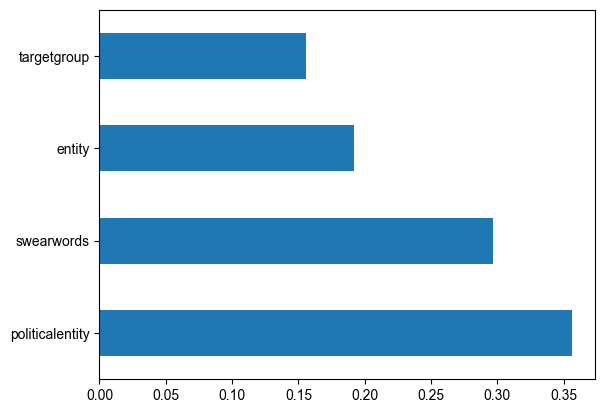

In [107]:


# find and plot feature importance
y_pred = clf1_nopreproc.predict(x_test)
clf1_nopreproc.feature_importances_
feat_importances = pd.Series(clf1_nopreproc.feature_importances_, index=X_features.columns)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = clf1_nopreproc.predict(x_test)
test_acc = accuracy_score(preds, y_test)

# determine best accuracy for validation set
preds_valid = clf1_nopreproc.predict(x_test)
valid_acc = accuracy_score(preds_valid, y_test)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")